# Assignment 2, Advanced Analytics in Business
# Jack Heller, Baris Aksoy, Medha Hegde, Aleksandra Zdravkovic, Group 31

Our goal is to build a deep learning model to predict the location of swimming pools in satellite images. The swimming pools were of varying shapes and so we explored predicting:
 1. the smallest upright bounding box containing the pool (Object Localisation)
 2. the polygon shape of the pool (Semantic Segmentation)

## Problem Definition

Our data set consists of 14,912 satellite images of swimming pools in the south of France. All images are the same size (512x512) and the pools are located in the centre of every image. All images are assumed to contain only one swimming pool. The metadata.json file contains the bounding polygon's coordinates. We aim to use this data to predict the location of the pools using convolutional neural networks.

## Importing required libraries

OpenCV was used for preprocessing the metadata and the images, as well as for visualisation purposes.
Tensorflow was used in order to create, train and evaluate the neural networks.

In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
from glob import glob
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

#model 1
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten

#model 2
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

## Preprocessing

### Metadata file
The metadata file containing the bounding polygon coordinates was used to extract:
1. the smallest upright bounding rectangle's coordinates: The openCV function *boundingRect* was used for this purpose. We divided each coordinate by 4 since the input images will be later resized to 128x128 from their original size of 512x512

2. the grayscale masks of each image containing the polygon area: The openCV function *fillConvexPoly* was used to obtain an image containing only the polygon of the pool (filled in black) and the remaining space filled in white. These images are saved locally to be used as masks for the second model.


In [3]:
f = open('metadata.json')
data = json.load(f)

#to extract rectangle coordinates + masks for each image

data_prepr={}
for pool in data:
    x_list = []
    y_list = []
    for bounds in data[pool]['bounds_x_y']:
        x_list = x_list + [bounds['x']]
        y_list = y_list + [bounds['y']]
    geom = list(zip(x_list, y_list))
    mask = np.zeros((512,512,3), dtype="float32")
    polyg = np.array([list(x) for x in (np.array(geom))], dtype=np.int32 )
    data_prepr[pool] = {'rect': tuple(int(d/4) for d in cv2.boundingRect(np.array([list(x) for x in (np.array(geom))], np.float32))), 'polyg': cv2.cvtColor(cv2.fillConvexPoly(mask,polyg, color=(255,255,255)),cv2.COLOR_BGR2GRAY).astype('float32')}

In [4]:
#sorted list of images by name
IMAGE_SIZE = 128
PATH = "/Users/medhahegde/Documents/Sem 2/Advanced Analytics/"
image_name_list = [x.split("/")[-1] for x in sorted(glob(PATH+"images/*.png"))]

In [ ]:
#save masks locally with same name as original images
for pool in image_name_list:
    cv2.imwrite(PATH+'masks/{}'.format(pool), data_prepr[pool]['polyg'])

## 1. Object Localisation

The purpose of object localisation is to locate the tightest rectangular bounding box centred on the swimming pool in the images. Using the images and the bounding box coordinates, we will train a ResNet50 CNN model to be able to predict these coordinates.






## Visualising the Bounding Box

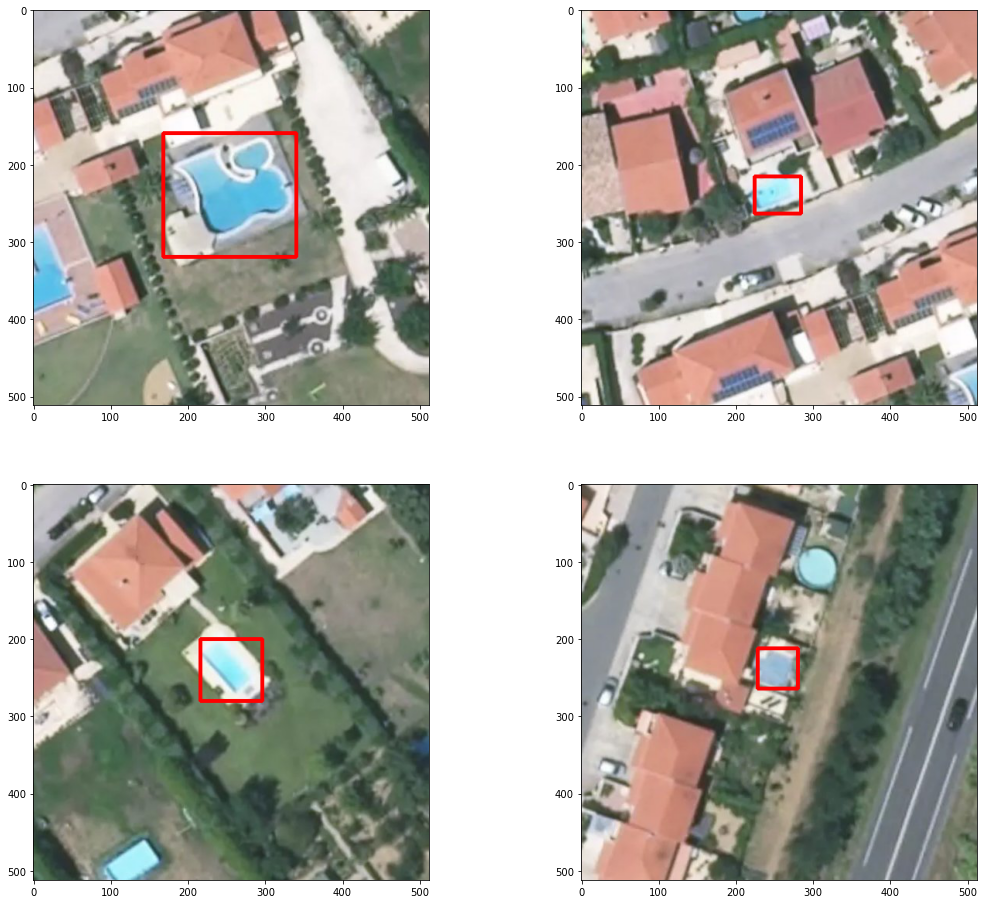

In [107]:
#plotting bounding box
f,subplots = plt.subplots(2,2,figsize=(18,16))
grids = [(0,0),(0,1),(1,0),(1,1)]
for i, img_name in enumerate(image_name_list[:4]):
    img = cv2.imread(PATH+'images/'+img_name)
    x,y,w,h = [x*4 for x in data_prepr[img_name]['rect']]
    bnd_img=cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),4)
    subplots[grids[i]].imshow(bnd_img[:,:,::-1])

### Feature Extraction

The keras image preprocessing utilites were used to load images into PIL format and then convert this into  Numpy array. This was then passed through the ResNet50 *preprocess_input* function which converts the input images from RGB to BGR, and then zero-centers each color channel with respect to the ImageNet dataset, without scaling.

The resulting output for each image is a 128x128 matrix with the zero-centered BGR coordinates for each pixel. This is the input format required for our model.

In [6]:
def load_img(path) :
    X = []
    for i in sorted(glob(path)) :
        img_path = i
        img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X.append(x)
    return np.asarray(X)

In [7]:
#loading X variables
X = load_img(PATH+'images/*.png')
X.shape

(14912, 128, 128, 3)

The bounding box coordinates for each image are then loaded into a Numpy array to be used as the target output for the model.

In [8]:
#loading dependent variables
coord_list=[]
for im in image_name_list:
    x,y,w,h = data_prepr[im]['rect']
    coord_list.append([x,y,x+w,y+h])
Y=np.asarray(coord_list)
Y=np.append(Y,[[x] for x in image_name_list],axis=1)

### Training, Validation and Testing Split

The preprocessed data is then split in a 80-10-10 ratio.

In [9]:
total_size = len(image_name_list)
valid_size = int(0.1 * total_size)
test_size = int(0.1 * total_size)

X_train, X_valid = train_test_split(X, test_size=valid_size, random_state=42)
y_train, y_valid = train_test_split(Y, test_size=valid_size, random_state=42)

X_train, X_test = train_test_split(X_train, test_size=test_size, random_state=42)
y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)

X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape

((11930, 128, 128, 3),
 (11930, 5),
 (1491, 128, 128, 3),
 (1491, 5),
 (1491, 128, 128, 3),
 (1491, 5))

In [10]:
#separating image file name column from data
img_train = y_train[:,-1]
y_train = y_train[:,:-1].astype(float)

img_valid = y_valid[:,-1]
y_valid = y_valid[:,:-1].astype(float)

img_test = y_test[:,-1]
y_test = y_test[:,:-1].astype(float)

## Model Definition: ResNet50 Architecture

We created a custom model using the ResNet-50 model which is a 50-layer convolutional neural network pretrained on more than a million images from ImageNet database. The base layers were frozen so that the ImageNet weights are not retrained. The final pooling and the fully connected top layers were not included so as to add our own final layers - these are the only layers which will be trained on our dataset.

We added a Flatten layer which converts the inputted layer into a one dimensional layer. This is then inputted into a final Dense Layer with 4 nodes corresponding to the 4 coordinates of the bounding box. A ReLu (Rectified Linear Unit) activation is applied since our required output conists of non-negative continuous numbers and the ReLu activation function does this by deactivating neurons whose output is less than zero.

The final model has 2,712,964 parameters, of which only 262,148 will be trained.


In [21]:
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model1.trainable = False

chopped_resnet1 = Model(inputs=[base_model1.input], outputs=[base_model1.layers[90].output])

localization_output1 = Flatten()(chopped_resnet1.output)
localization_output1 = Dense(units=4, activation='relu')(localization_output1)

model1 = Model(inputs=[chopped_resnet1.input], outputs=localization_output1)
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

## Model Configuration

The custom model is configured as follows:

1. Loss function: A loss function is used to compare the model's predicted values to the ground truth values of the bounding box coordinates. We will the Mean Squared Error loss function for this purpose.

2. Optimizer: The *Adam* optimization algorithm is used to update the network's weights at every epoch in order to "guide" the model towards minimizing the loss, here the MSE.

3. Metrics: The Mean Squared Error is also used as a metric to monitor the training and testing steps



In [23]:
model1.compile(optimizer='adam', metrics=['mse'],loss=['mse'])

## Model Training

The model is then trained on our training data and is also validated at every step using our validation data.
We have trained the model for 20 epochs and used a batch size of 500 since we found that this combination works most efficiently with our current capacities of time and computing power.

From the output of the training, we see that both the training and validation losses reduce after each epoch. The final loss (MSE) for the training set computed at the end of 20 epochs is 2.62 from an initial loss of 476.33 at the first epoch. The final validation loss is 3.87.

In [24]:
history2=model1.fit(X_train, y_train, validation_data=(X_valid, y_valid),epochs=20,verbose=True,batch_size=500)
history2

Epoch 1/20


2022-05-23 18:00:58.436182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 476.3326 - mse: 476.3326

2022-05-23 18:01:30.295576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 37s 1s/step - loss: 476.3326 - mse: 476.3326 - val_loss: 140.9883 - val_mse: 140.9883
Epoch 2/20
24/24 [==============================] - 33s 1s/step - loss: 37.4954 - mse: 37.4954 - val_loss: 17.5312 - val_mse: 17.5312
Epoch 3/20
24/24 [==============================] - 36s 2s/step - loss: 8.9866 - mse: 8.9866 - val_loss: 6.0910 - val_mse: 6.0910
Epoch 4/20
24/24 [==============================] - 36s 2s/step - loss: 5.2816 - mse: 5.2816 - val_loss: 4.8771 - val_mse: 4.8771
Epoch 5/20
24/24 [==============================] - 32s 1s/step - loss: 4.5074 - mse: 4.5074 - val_loss: 4.4753 - val_mse: 4.4753
Epoch 6/20
24/24 [==============================] - 31s 1s/step - loss: 4.1246 - mse: 4.1246 - val_loss: 4.2880 - val_mse: 4.2880
Epoch 7/20
24/24 [==============================] - 31s 1s/step - loss: 3.8553 - mse: 3.8553 - val_loss: 4.1676 - val_mse: 4.1676
Epoch 8/20
24/24 [==============================] - 31s 1s/step - loss: 3.6602 - mse: 3.6

## Visualizing Training

Both the training and validation losses drop fairly quickly by the 2nd epoch with very small decreases towards the minimum in the subsequent epochs.

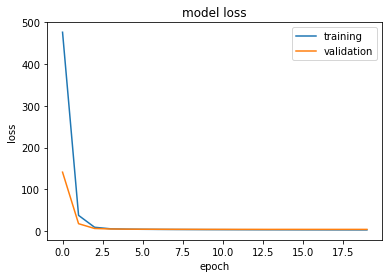

In [27]:
def plot_training_history(history, model):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()
plot_training_history(history2, model1)

## Model Evaluation

The model was evaluated on the test dataset using 2 metrics: MSE and IOU (Intersection over Union).
The MSE was found to be 4.02, which is not far from the model's 2.62.

### Intersection Over Union
The IOU is used to measure the overlap between the ground truth and the predicted bounding boxes. It is measured as the region of overlap divided by the combined region covered by the bounding boxes. The closer this number is to 1, the more accurate our model is at predicted the correct bounding box coordinates.

For our model's prediction on the test dataset, the average IOU is **0.86**.


In [26]:
loss, mse = model1.evaluate(X_test, y_test, verbose=2)
print("Model Mean Squared Error: {:5.2f}".format(mse))

47/47 - 5s - loss: 4.0240 - mse: 4.0240 - 5s/epoch - 104ms/step
Model Mean Squared Error:  4.02


In [28]:
y_predict =model1.predict(X_test)

2022-05-23 18:18:24.183421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [29]:
def iou2(bounding_box, compare_box):
    xA = max(bounding_box[0], compare_box[0])
    yA = max(bounding_box[1], compare_box[1])
    xB = min(bounding_box[2], compare_box[2])
    yB = max(bounding_box[3], compare_box[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (bounding_box[2] - bounding_box[0] + 1) * (bounding_box[3] - bounding_box[1] + 1)
    boxBArea = (compare_box[2] - compare_box[0] + 1) * (compare_box[3] - compare_box[1] + 1)
    iou =interArea/float(boxAArea+boxBArea-interArea)
    return iou

In [30]:
iou_list=[]
for y_ind in range(y_predict.shape[0]-1):
    iou_list.append(iou2(y_predict[y_ind],y_test[y_ind]))
print("Average Intersection over Union is",np.mean(iou_list))

Average Intersection over Union is 0.8575635593641316


### Visualizing Predictions

Below, we visualize the model's prediction on 5 random images from the test dataset. The green bounding boxes on the right are the predicted outputs.

43.6852747_1.4418763.png
42.7283932_2.937063.png
42.7266979_2.9261126.png
43.5632504_1.2946177.png
43.8387605_1.3796636.png


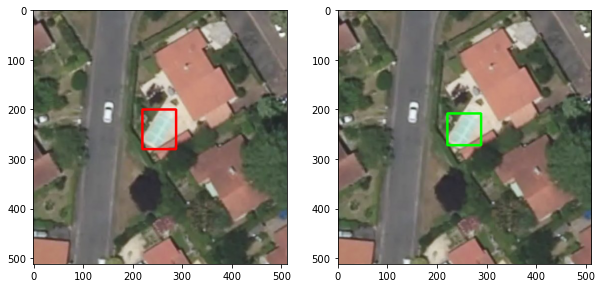

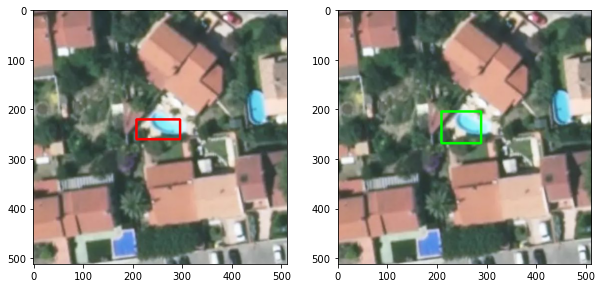

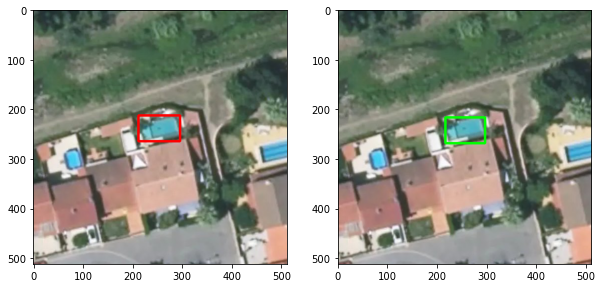

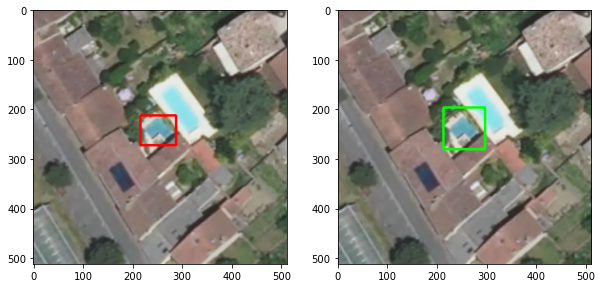

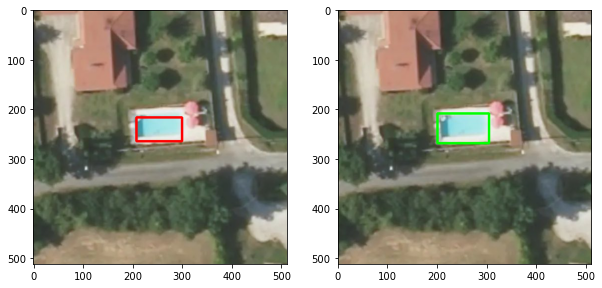

In [109]:
#plotting bounding box for predictions
for i in random.sample(range(0, len(y_predict)-1), 5):

    img_name=img_test[i]
    img = cv2.imread(PATH+'images/'+img_name)
    # img=cv2.resize(img,(128,128))

    x,y,w,h = [x*4 for x in data_prepr[img_name]['rect']]
    bnd_img=cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),4)

    #plt.imshow(bnd_img[:,:,::-1])

    #plotting bounding box for predictions
    img2 = cv2.imread(PATH+'images/'+img_name)
    # img2=cv2.resize(img2,(128,128))

    img_index = np.where(img_test==img_name)[0][0]
    coords = [x*4 for x in y_predict[img_index].astype(int)]
    # print(coords)

    bnd_img2=cv2.rectangle(img2,(coords[0],coords[1]),(coords[2],coords[3]),(0,255,0),4)
    #plt.imshow(bnd_img2[:,:,::-1])

    print(img_name)
    f,subplots = plt.subplots(1,2,figsize=(10,6))
    subplots[0].imshow(bnd_img[:,:,::-1])
    subplots[1].imshow(bnd_img2[:,:,::-1])



# 2. Semantic Segmentation

Semantic segmentation is the process of pixel-wise prediction where each pixel is classified as either belonging to the object (pool) or not. The inputs to the model will similar to those of the previous model. The output, however is no longer the 4 bounding box coordinates. Instead, the output is a Numpy array represensation of an image where each cell in the matrix represetns a pixel with 1 if it belongs to the bounding polygon (pool) and 0 if it does not.

In [96]:
#hyperparameters
np.random.seed(42)
tf.random.set_seed(42)
EPOCHS = 10
BATCH = 4
LR = 0.001

### Training, Validation and Testing Split

The data is split in a 80-10-10 ratio.

In [97]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

## Reading in Images and Masks

The input images are preprocessed in a different manner than the first model. The image is first resized to 128x128 and then the RGB coordinates are normalized by dividing by 255.

The output (masks) are the same dimensions as the input image (128x128), but each pixel only contains one value instead of 3 values for the RGB coordinates, since the masks are in grayscale.

In [85]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

## Further Preprocessing

The outputs of the above functions are further processed to create a Tensorflow Dataset.

In [86]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [87]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  11930
Validation data:  1491
Testing data:  1491


In [93]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [88]:
#function to read images
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

## Visualizing Images and Masks

### What is a *mask*?

A mask is an image that is modified such that pixels belonging to the same object have the same color. They are the target output of the segmentation model since they represent the area of the image that we are trying to identify. For our problem, since we have only one image, we only have one colour demarcating the area of the pool in the image.

In the images below, we see the original image and their corresponding masks:

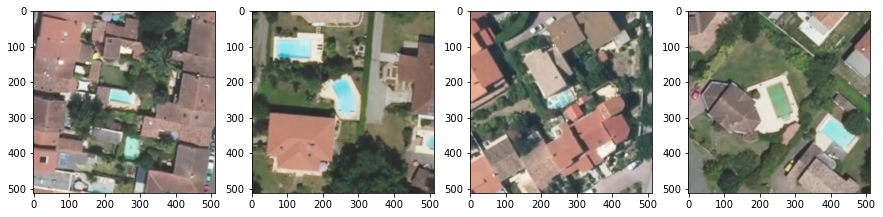

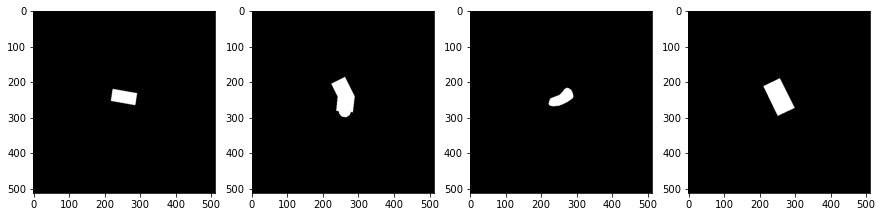

In [89]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

## Model Definition: U-Net Architecture with MobileNetV2

The U-Net model consists of a contraction path (encoder) and expansive path (decoder).
The former uses traditional convolutional layers while the latter uses symmetric transposed convolutions which performs upsampling, a method to increase the "resolution" of an inputted image. The U-net is a Fully Convolutional Network (FCN).

We are using the MobileNetV2 architecture for the contraction path of the U-Net model since it is pretrained and will help the final model converge much faster. We then replace sertain layers with Upsampling and Convolutional layers  to form the second half of the U-Net.


In [98]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [99]:
model = model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]']         

## Model Configuration

### Defining Loss and Metrics Functions

We are using the Sørensen–Dice coefficient as a metric to evaluate the model. It works in a similar way to Intersection over Union metric but is more often for image segmentation models. It is calculated as 2 times the area of intersection (of ground truth and predicted polygons) divided by the sum of their areas. This metric ranges from 0 to 1, with 1 being a perfect model. We are additionally looking at Recall and Precision during training.

We use the complement of this coefficient as the loss function to be minimized during training.

In [34]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

### Optimizer

We are using the NAdam algorthm as the optimizer for the model. It is essentially the Adam algorithm with Nestrov momentum.

In [94]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

### Callbacks

We are using the Keras callbacks API to:
1. Reduce learning rate by a factor of 0.1 when the Dice Coefficient loss has stopped improving for 4 epochs
2. Stop training when the Dice Coefficient loss has stopped improving for 4 epochs, and retain the weights of the last step of training

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=False)
]

## Model Training

The model is then trained on our training data and is also validated at every step using our validation data.
We have trained the model for 10 epochs only.

From the output of the training, we see that both the training and validation losses reduce after each epoch. The final Dice Coefficient for the training set computed is 0.89 while for the validation set is 0.87. The final Precision and Recall for the validation set is 0.91 and 0.83, respectively.

In [96]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/10


2022-05-21 21:44:30.641914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2983/2983 [==============================] - ETA: 0s - loss: 0.2369 - dice_coef: 0.7631 - recall_4: 0.8380 - precision_4: 0.6298

2022-05-21 21:51:05.868724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2983/2983 [==============================] - 413s 131ms/step - loss: 0.2369 - dice_coef: 0.7631 - recall_4: 0.8380 - precision_4: 0.6298 - val_loss: 0.1778 - val_dice_coef: 0.8222 - val_recall_4: 0.9053 - val_precision_4: 0.7744 - lr: 0.0010
Epoch 2/10
2983/2983 [==============================] - 379s 127ms/step - loss: 0.1330 - dice_coef: 0.8670 - recall_4: 0.8411 - precision_4: 0.8940 - val_loss: 0.1588 - val_dice_coef: 0.8412 - val_recall_4: 0.9186 - val_precision_4: 0.7992 - lr: 0.0010
Epoch 3/10
2983/2983 [==============================] - 394s 132ms/step - loss: 0.1262 - dice_coef: 0.8738 - recall_4: 0.8479 - precision_4: 0.9000 - val_loss: 0.1382 - val_dice_coef: 0.8619 - val_recall_4: 0.8930 - val_precision_4: 0.8488 - lr: 0.0010
Epoch 4/10
2983/2983 [==============================] - 1003s 336ms/step - loss: 0.1220 - dice_coef: 0.8779 - recall_4: 0.8532 - precision_4: 0.9033 - val_loss: 0.1292 - val_dice_coef: 0.8709 - val_recall_4: 0.8701 - val_precision_4: 0.8817 - lr: 0.001

## Model Evaluation

The model was evaluated on the test dataset using the metrics Dice Coefficient, Recall and Precision:

Dice Coefficient: **0.87**
Recall: **0.83**
Precision: **0.91**

Based on these metrics, we evaluate the model to be a good predictor of the area in the image that belongs to a swimming pool.


In [97]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

373/373 [==============================] - 15s 40ms/step - loss: 0.1230 - dice_coef: 0.8770 - recall_4: 0.8394 - precision_4: 0.9148


[0.12304575741291046,
 0.8769917488098145,
 0.8394309282302856,
 0.914832592010498]

## Visualising Predictions

Below, we visualize 10 predicted mask images that is outputted by the model on the test dataset. The middle column is the ground truth while the last column on the right is the prediction. We can see that the model does a good job of classifying pixels, especially on the last image where it appears to be predicting better than the ground truth mask itself.

In [98]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

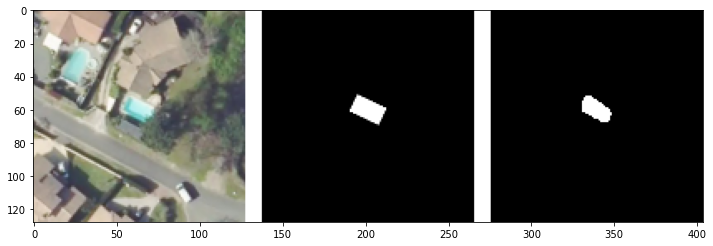

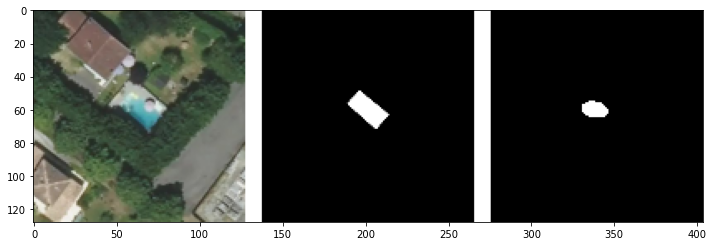

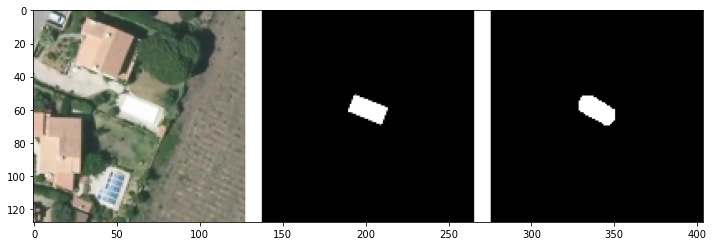

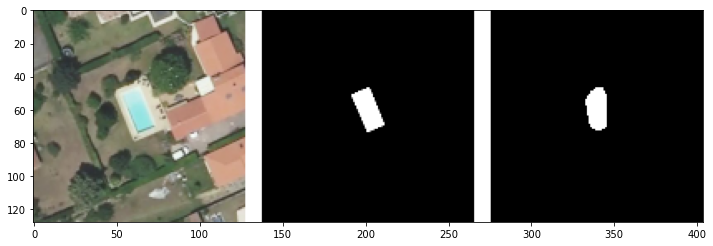

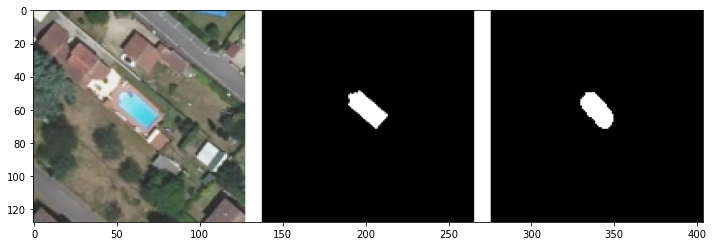

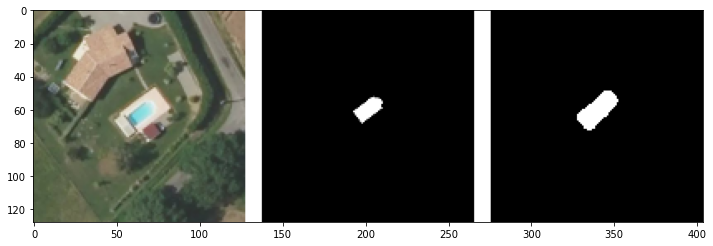

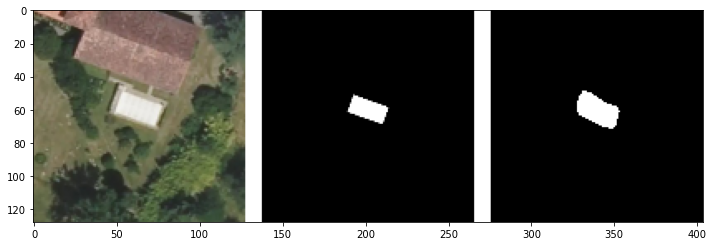

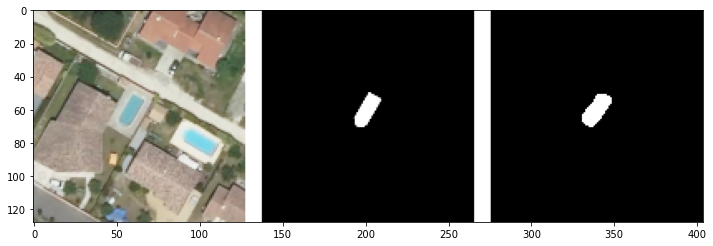

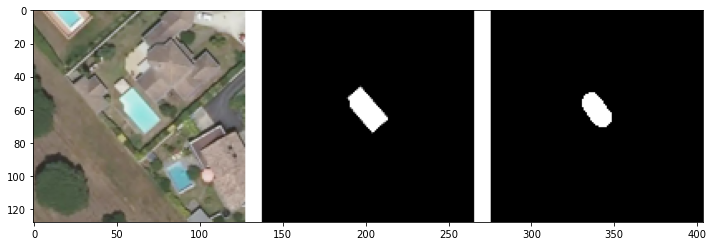

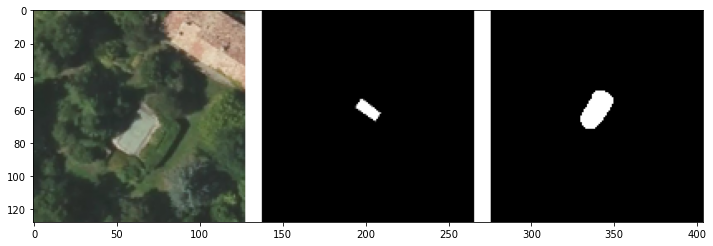

In [100]:
for i, (x, y) in enumerate(zip(test_x[0:10], test_y[0:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)